# Final Project - Kaggle Rossmann Store Sales

This is the udacity final proejct, also a kaggle competition, [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales/data).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from datetime import datetime
from datetime import timedelta

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

## 1 Import data and explore data

In [22]:
storeData = pd.read_csv('data/store.csv')
testData = pd.read_csv('data/test.csv')
trainData = pd.read_csv('data/train.csv')

D:\01_MLNewWorld\NN_Anaconda3\envs\nn\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [660]:
storeData.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
storeData.shape

(1115, 10)

### 1.1 Data Preparation Consideration

So there are 1115 stores need analyze. Each store has 9 diamension to descript. Also, can define strategy for each columns.

- **StoreType**, **Assortment**, **CompetitionOpenSinceYear** should be encode as number.

- **CompetitionDistance** and **CompetitionOpenSinceMonth** should be normalize.

- **Promo2SinceWeek** and **Promo2SinceYear** should carefully treated becasue quite a lot NaN value appear here. 

In [658]:
trainData.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


### 1.2 Decision Making

General, the principle decision is to train one model, take store number as an input, to predict result. The planned model is LSTM with pytorch.

The process decided are:

1. Data cleaning. Merge the store data with train data, remove bad data
2. Data augumentation. Discuss whether any way to augument the origin data, also maybe contexualize the data
3. Model build up and training

## 2 Data Processing
Firstly I'll merge the train with store as one. Due to the fact that later on test data will perform the same merging, a function is designed to re-use the code.

In [426]:
def dataMergingAndDateConvert(inputData, storeData=storeData):
    df = pd.merge(inputData, storeData, on='Store', how='outer')
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [427]:
pdTrain = dataMergingAndDateConvert(trainData, storeData)
pdTrain.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


### 2.1 Data Visualization

Let's have a look at the data first. We need find answer for following question:
- The repeat pattern. Weekly? Sessional? Yearly?
- Sales trend
- Correlation between different store in terms of sales figure
- Correlation between store sales and store data

Before Visualization, the NaN is removed to enable value analyze. First of all we try to find where NaN is located.

In [428]:
pdTrain.isin([np.NaN]).sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

To make later analyze more stable, the replaced value is the average of current column.


In [429]:
# process all valued NaN
pdTrain.iloc[:,:-1] = pdTrain.drop('PromoInterval', axis=1).fillna(pdTrain.mean())
# process the rest, PromoInterval, with string 'invalid'
pdTrain.fillna('invalid', inplace=True)

#### 2.1.1 Weekly Pattern
Let's firtly investigate weekly pattern

In [430]:
# Get a random number to loop for numbers of week
startD = pd.to_datetime('2013-4-22')

# Define a function to print 6 weeks of data for targeting store
def printWeeksDataForStores(storeNum=[1, 2, 3], df=pdTrain, weeksNum=9, dashPlot=False):
    printDate = []
    printSale = []
    printStore = []
    
    for store in storeNum:
        storeSales = df.loc[df['Store']==store].copy()
        # sort by date
        storeSales.sort_values(by='Date', ascending=True, inplace=True)
        storeSales.reset_index(inplace=True)

        # get correct index
        startDIndex = storeSales.loc[storeSales['Date']==startD].index.values[0]

        for i in range(weeksNum):
            storeSalesWeeksDate = storeSales.iloc[startDIndex + 7*i:startDIndex+7*(i+1), 3]
            printDate = printDate + list(storeSalesWeeksDate.values)

            storeSalesWeeksSales = storeSales.iloc[startDIndex + 7*i:startDIndex+7*(i+1), 4]
            printSale = printSale + list(storeSalesWeeksSales.values)
            
            printStore = printStore + [int(store)] * 7
    
    zippedList =  list(zip(printDate, printSale, printStore))
    printDatadf = pd.DataFrame(data=zippedList, columns=['Date', 'Sales', 'Stores'])

    fig = plt.figure(figsize=(20,8))

    printDatadf['Stores'] = printDatadf['Stores'].astype('category')
    ax = sns.lineplot(data=printDatadf, x ='Date', y ='Sales', hue ='Stores', marker='o', estimator=None, dashes=True)
    plt.xticks(rotation=15)
    
    if dashPlot==True and weeksNum==9:
        xDashed = [pd.to_datetime('2013-4-22'), pd.to_datetime('2013-4-29'), pd.to_datetime('2013-5-6'),
                   pd.to_datetime('2013-5-13'), pd.to_datetime('2013-5-20'), pd.to_datetime('2013-5-27'),
                   pd.to_datetime('2013-6-3'), pd.to_datetime('2013-6-10'), pd.to_datetime('2013-6-17')]
        for xD in xDashed:
            plt.axvline(x=xD, linestyle='dashed')
    
    ax.set_title("{} weeks of sales trend starting from {}".format(weeksNum, startD.strftime("%Y-%m-%d")))

    plt.show()

    return printDatadf

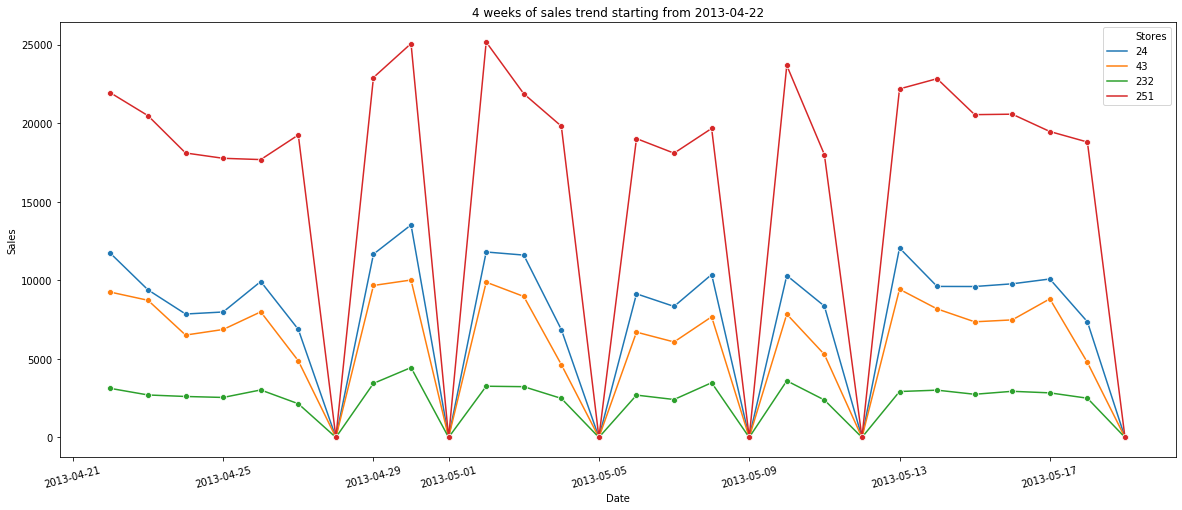

In [431]:
nop = printWeeksDataForStores([24, 43, 232, 251], weeksNum=4)

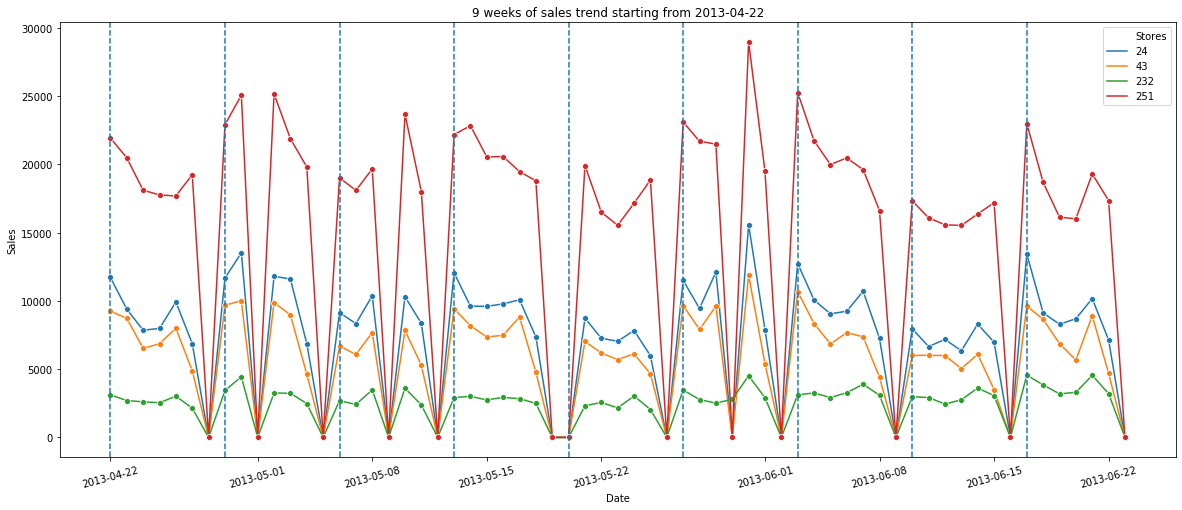

In [432]:
nop = printWeeksDataForStores([24, 43, 232, 251], weeksNum=9, dashPlot=True)

In [433]:
pdTrain.loc[(pdTrain['Date']==pd.to_datetime('2013-04-28')) & (pdTrain['Store']==251)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
228044,251,7,2013-04-28,0,0,0,0,0,0,a,c,340.0,7.222866,2008.690228,0,23.269093,2011.752774,invalid


Apparrently if the store is not open, there won't be any sales...

#### 2.1.2 Yearly Pattern
Let's firtly investigate yearly pattern

In [434]:
# Define a function to print 6 weeks of data for targeting store
def printYearsDataForStores(storeNum=[1, 2, 3], df=pdTrain, dashPlot=False):
    printDate = []
    printSale = []
    printStore = []
    yearNum=2
    
    for store in storeNum:
        storeSales = df.loc[df['Store']==store].copy()
        # sort by date
        storeSales.sort_values(by='Date', ascending=True, inplace=True)
        storeSales.reset_index(inplace=True)

        # get correct index
        startDIndex = storeSales.loc[storeSales['Date']==startD].index.values[0]

        for i in range(yearNum):
            storeSalesYearsDate = storeSales.iloc[startDIndex + 365*i:startDIndex+365*(i+1), 3]
            printDate = printDate + list(storeSalesYearsDate.values)

            storeSalesYearsSales = storeSales.iloc[startDIndex + 365*i:startDIndex+365*(i+1), 4]
            printSale = printSale + list(storeSalesYearsSales.values)
            
            printStore = printStore + [int(store)] * 365
    
    zippedList =  list(zip(printDate, printSale, printStore))
    printDatadf = pd.DataFrame(data=zippedList, columns=['Date', 'Sales', 'Stores'])

    fig = plt.figure(figsize=(20,8))

    printDatadf['Stores'] = printDatadf['Stores'].astype('category')
    ax = sns.lineplot(data=printDatadf, x ='Date', y ='Sales', hue ='Stores', estimator=None)
    plt.xticks(rotation=15)
    
    if dashPlot==True:
        xDashed = pd.to_datetime('2014-4-29')
        plt.axvline(x=xDashed, linestyle='dashed')
    
    ax.set_title("{} years of sales trend starting from {}".format(yearNum, startD.strftime("%Y-%m-%d")))

    plt.show()

    return printDatadf

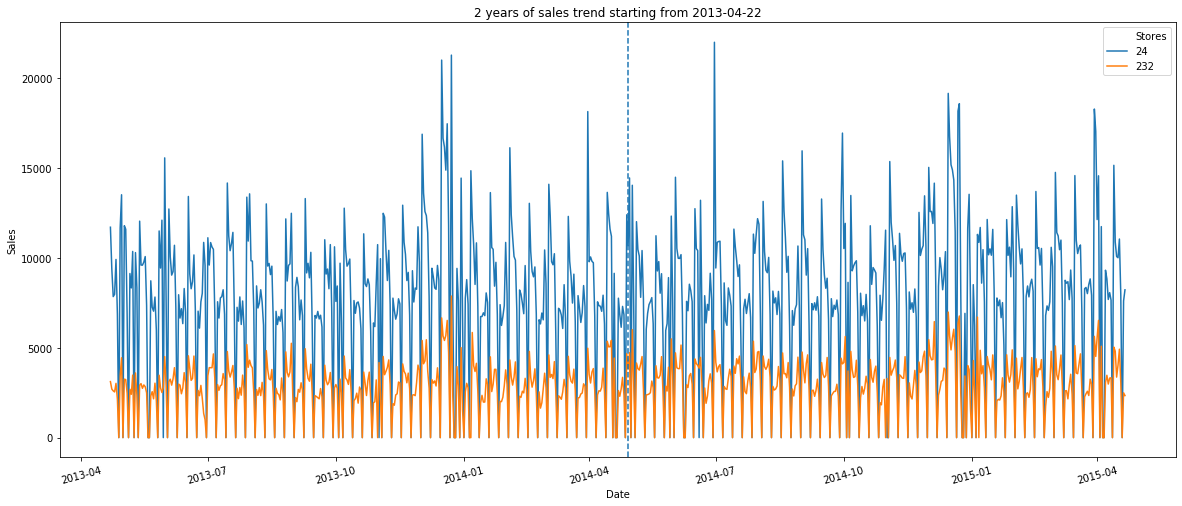

In [435]:
nop = printYearsDataForStores([24, 232], dashPlot=True)

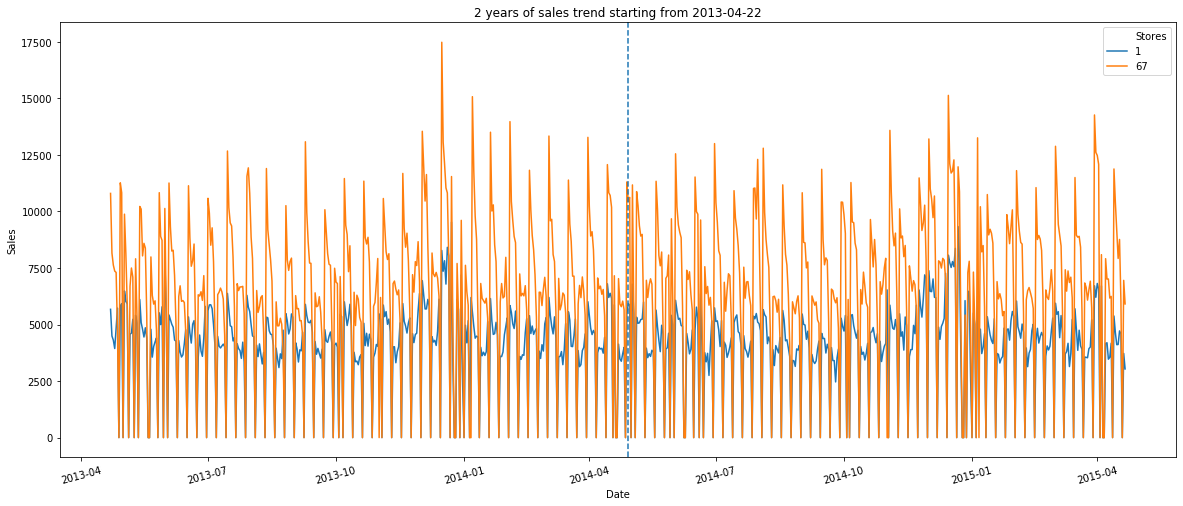

In [436]:
nop = printYearsDataForStores([1, 67], dashPlot=True)

#### 2.1.3 Summary of Data Trend Analysis
Clearly we can see pattern from weekly and yearly perspective. Weekly speaking, Monday has most significant sales figure, then it drops along the week. Besides, if the store is not open, it won't have any sales.

Yearly speaking, there do have a repeating pattern. Especially during X-mas, the sales figure sigificantly higher than average and this pattern repeat over years.

Therefore, the model we build must be able to remeber pattern in a year-base repeating pattern.

#### 2.1.4 Sales Trend Analysis
Now analyze the sales trend cross the data over years. I'll basically print every week's average sales cross the dataset.

In [437]:
daysInData = (pdTrain['Date'].max() - pdTrain['Date'].min()).days

def printTrendforStores(storeNum=[1, 2, 3], df=pdTrain, dashPlot=False):
    printDate = []
    printSale = []
    printStore = []
    
    for store in storeNum:
        storeSales = df.loc[df['Store']==store].copy()

        storeSales.sort_values(by='Date', ascending=True, inplace=True)
        storeSales.reset_index(inplace=True)
        
        # get weekly average
        for i in range(int(daysInData / 7)):
            # set every monday as the index
            storeSalesDate = storeSales.iloc[7*i, 3]
            printDate = printDate + [storeSalesDate]

            storeSalesWeeklySales = storeSales.iloc[7*i:7*(i+1), 4]
            storeSalesWeeklyFigure = storeSalesWeeklySales.sum()/7
            printSale = printSale + [storeSalesWeeklyFigure]
            
            printStore = printStore + [int(store)]
    
    zippedList =  list(zip(printDate, printSale, printStore))
    printDatadf = pd.DataFrame(data=zippedList, columns=['Date', 'Sales', 'Stores'])

    fig = plt.figure(figsize=(20,8))

    printDatadf['Stores'] = printDatadf['Stores'].astype('category')
    ax = sns.lineplot(data=printDatadf, x ='Date', y ='Sales', hue ='Stores', estimator=None)
    plt.xticks(rotation=15)
    
    if dashPlot==True:
        xDashed = [pd.to_datetime('2013-1-1'), pd.to_datetime('2014-1-1'), pd.to_datetime('2015-1-1')]
        for xD in xDashed:
            plt.axvline(x=xD, linestyle='dashed')
    
    ax.set_title("Overall sales trend for different stores")

    plt.show()

    return printDatadf

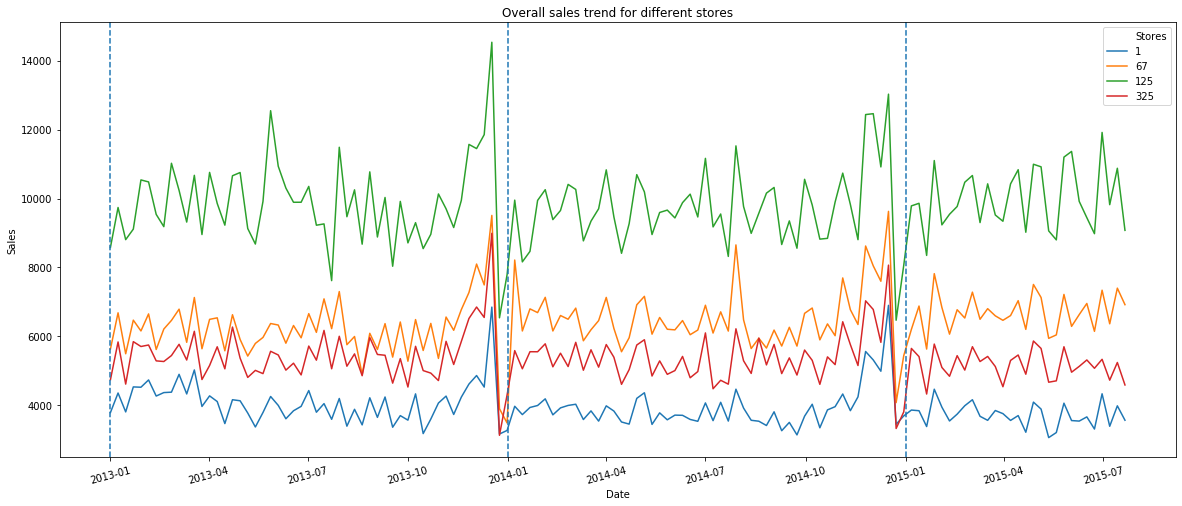

In [438]:
nop = printTrendforStores([1, 67, 125, 325], dashPlot=True)

#### 2.1.5 Summary of Overall Data Trend Analysis
The data trend is more or less stable, no going up or down in almost 3 year aspect. This analyze also prove that the yearly pattern exist and should remember by algorithm.

#### 2.1.6 Correlation Analyze
Two kinds of correlation is studied here, which are:
- Correlation between different store in terms of sales figure
- Correlation between store sales and store information

I'll use heatmap to illustrate those information.

**Due to heatmap need either value/string members. It is done after label encoding/standardize**

### 2.2 Label Encoding
Now use sklearn label encoding method to encode **StoreType**, **Assortment** and **PromoInterval**.

In [439]:
from sklearn.preprocessing import LabelEncoder

In [440]:
stringEncoder = LabelEncoder()
pdTrain['Assortment'] = stringEncoder.fit_transform(pdTrain['Assortment'])
pdTrain['StoreType'] = stringEncoder.fit_transform(pdTrain['StoreType'])
pdTrain['PromoInterval'] = stringEncoder.fit_transform(pdTrain['PromoInterval'])
pdTrain['StateHoliday'] = stringEncoder.fit_transform(pdTrain['StateHoliday'].astype(str))
pdTrain.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3
1,1,4,2015-07-30,5020,546,1,1,0,1,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3
2,1,3,2015-07-29,4782,523,1,1,0,1,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3
3,1,2,2015-07-28,5011,560,1,1,0,1,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3
4,1,1,2015-07-27,6102,612,1,1,0,1,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3
5,1,7,2015-07-26,0,0,0,0,0,0,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3
6,1,6,2015-07-25,4364,500,1,0,0,0,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3
7,1,5,2015-07-24,3706,459,1,0,0,0,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3
8,1,4,2015-07-23,3769,503,1,0,0,0,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3
9,1,3,2015-07-22,3464,463,1,0,0,0,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,3


### 2.3 Data Standardization
Most important data needs to standardize is **Sales**, which is also our prediction value. The scaler chosen here is MinMaxScaler. Original thought was with StandardScaler, this is to avoid effect that one store with great sale suppress others weight. As histogram shown below, quite a large number of stores have a relatively low sales. However, the LSTM need a sales input with range from 0-1. So for sales, the scaler is changed to MinMaxScaler.

Besides, **Customers** and **CompetitionDistance** use the same approach to standardize.

For **CompetitionOpenSinceYear**,  Then the year should be label in a manner that the year order preserve. That is to say its also good to use standardize factor to scale the years information, instead of label with random number.

In [457]:
# Import scalar to process
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [458]:
scalar = MinMaxScaler()
scalar.fit(trainData['Sales'].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [443]:
pdTrain['Sales'] = scalar.transform(pdTrain['Sales'].values.reshape(-1,1))

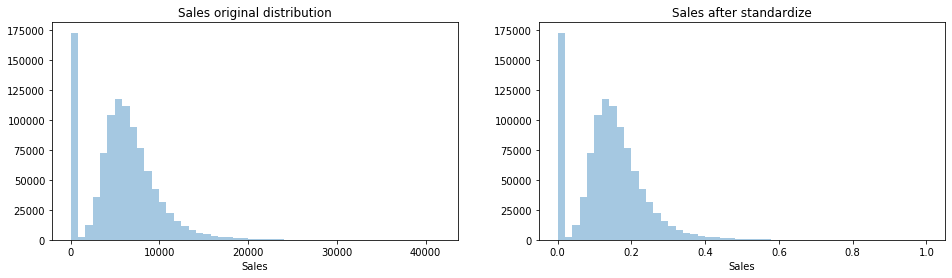

In [444]:
fig = plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
ax = sns.distplot(trainData['Sales'], bins=50, kde=False, norm_hist=False)
fig = ax.set_title('Sales original distribution')

plt.subplot(1,2,2)
ax = sns.distplot(pdTrain['Sales'], bins=50, kde=False, norm_hist=False)
fig = ax.set_title('Sales after standardize')
plt.show()

In [381]:
custScalar = StandardScaler()
custScalar.fit(trainData['Customers'].values.reshape(-1,1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [382]:
pdTrain['Customers'] = custScalar.transform(pdTrain['Customers'].values.reshape(-1,1))

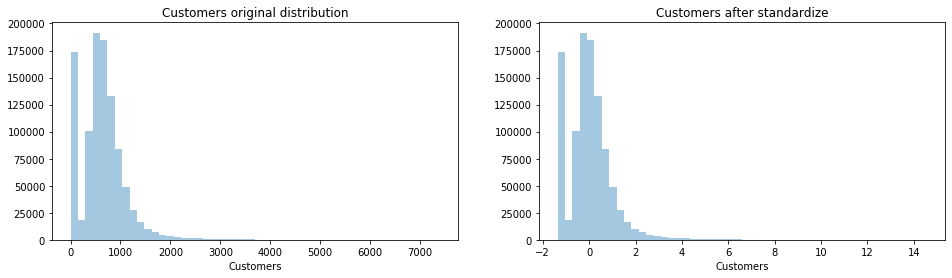

In [383]:
fig = plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
ax = sns.distplot(trainData['Customers'], bins=50, kde=False, norm_hist=False)
fig = ax.set_title('Customers original distribution')

plt.subplot(1,2,2)
ax = sns.distplot(pdTrain['Customers'], bins=50, kde=False, norm_hist=False)
fig = ax.set_title('Customers after standardize')
plt.show()

In [384]:
comDisScalar = StandardScaler()
comDisScalar.fit(storeData['CompetitionDistance'].values.reshape(-1,1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [385]:
pdTrain['CompetitionDistance'] = comDisScalar.transform(pdTrain['CompetitionDistance'].values.reshape(-1,1))

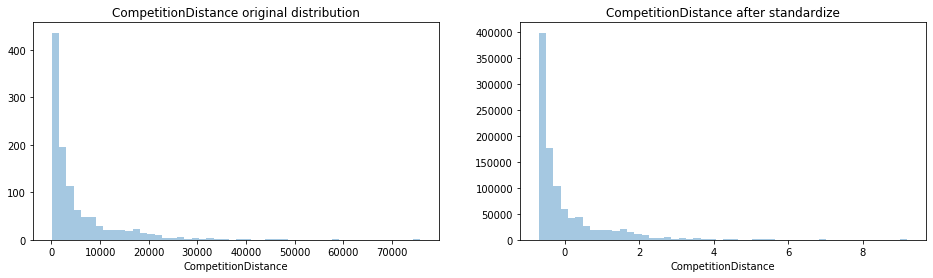

In [386]:
fig = plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
ax = sns.distplot(storeData['CompetitionDistance'], bins=50, kde=False, norm_hist=False)
fig = ax.set_title('CompetitionDistance original distribution')

plt.subplot(1,2,2)
ax = sns.distplot(pdTrain['CompetitionDistance'], bins=50, kde=False, norm_hist=False)
fig = ax.set_title('CompetitionDistance after standardize')
plt.show()

### 2.4 Special Treatment for Years

For year information such as **CompetitionOpenSinceYear** and **Promo2SinceYear**, I want to preserve the year information in a manner the age information also preserve. To do so, a year scaler is used. This year will fit on **CompetitionOpenSinceYear**, and apply to both columns. This is because **CompetitionOpenSinceYear** covers more year range.

In [387]:
pdTrain['Promo2SinceYear'].value_counts()

2011.752774    508031
2011.000000    115056
2013.000000    110464
2014.000000     79922
2012.000000     73174
2009.000000     65270
2010.000000     56240
2015.000000      9052
Name: Promo2SinceYear, dtype: int64

In [388]:
yearScalar = StandardScaler()
yearScalar.fit(storeData['Promo2SinceYear'].values.reshape(-1,1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [389]:
pdTrain['Promo2SinceYear'] = yearScalar.transform(pdTrain['Promo2SinceYear'].values.reshape(-1,1))
pdTrain['CompetitionOpenSinceYear'] = yearScalar.transform(pdTrain['Promo2SinceYear'].values.reshape(-1,1))

### 2.5 Special Treatment for Week/Month and label Information

For better train the model, week and numbered label columns, those parameters are all multiply by factor 0.1 to reduce the range. Attempt to make the model more stable. Those columns including: **Promo2SinceWeek**, **CompetitionOpenSinceMonth**, **Assortment**, **PromoInterval** and **StoreType**

In [390]:
pdTrain['StoreType'] = pdTrain['StoreType'].apply(lambda x: 0.1 * x)
pdTrain['Assortment'] = pdTrain['Assortment'].apply(lambda x: 0.1 * x)
pdTrain['CompetitionOpenSinceMonth'] = pdTrain['CompetitionOpenSinceMonth'].apply(lambda x: 0.1 * x)
pdTrain['Promo2SinceWeek'] = pdTrain['Promo2SinceWeek'].apply(lambda x: 0.1 * x)
pdTrain['PromoInterval'] = pdTrain['PromoInterval'].apply(lambda x: 0.1 * x)

In [391]:
pdTrain.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,0.126664,-0.168269,1,1,0,1,0.2,0.0,-0.539823,0.9,-1202.156413,0,2.326909,-0.006453,0.3
1,1,4,2015-07-30,0.120815,-0.187648,1,1,0,1,0.2,0.0,-0.539823,0.9,-1202.156413,0,2.326909,-0.006453,0.3
2,1,3,2015-07-29,0.115087,-0.237173,1,1,0,1,0.2,0.0,-0.539823,0.9,-1202.156413,0,2.326909,-0.006453,0.3
3,1,2,2015-07-28,0.120599,-0.157502,1,1,0,1,0.2,0.0,-0.539823,0.9,-1202.156413,0,2.326909,-0.006453,0.3
4,1,1,2015-07-27,0.146856,-0.045533,1,1,0,1,0.2,0.0,-0.539823,0.9,-1202.156413,0,2.326909,-0.006453,0.3


### 2.6 Complete Correlation Analyze
- Correlation between different store in terms of sales figure
- Correlation between store sales and store information

In [392]:
# To reduce calculation time, we only investigate first 100 stores, for the first 1 year sales data
storeCorrDf = pdTrain[['Date', 'Store', 'Sales']].copy()
storeCorrDf = storeCorrDf.loc[storeCorrDf['Store']<=100]

In [393]:
storeCorrData = []
for i in range(365):
    entry = []
    date = storeCorrDf['Date'].min() + timedelta(days=i)
    entry.append(date)
    for j in range(99):
        entry.append(storeCorrDf.loc[(storeCorrDf['Store'] == j+1) & (storeCorrDf['Date'] == date), 'Sales'].values[0])
    
    storeCorrData.append(entry)

In [394]:
storeCorrDataDf = pd.DataFrame(storeCorrData).drop(0, axis=1)

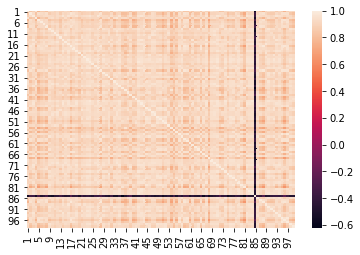

In [395]:
storeSalesCorrMatrix = storeCorrDataDf.corr()
sns.heatmap(storeSalesCorrMatrix)

In [396]:
corr_matrix = pdTrain.drop(['Store', 'Date', 'DayOfWeek'], axis=1).astype(float).corr()

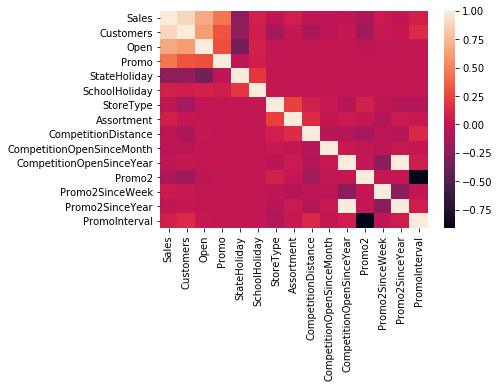

In [397]:
sns.heatmap(corr_matrix)

#### 2.6.1 Complete Correlation Analyze Result
##### Correlation between different store in terms of sales figure
There do have correlation between different store, and their correlation is in a average high factor. This is maybe because those stores are in similar location, therefore, they have similar holiday or other impact. Besides, I do notice there's one store that has totally in-correlate with others. Maybe its basically another location.

##### Correlation between store sales and store information
According to the heatmap, the most reletive figure to sales are Customers and Open, and Customer is also heavily relative to Open.

In [398]:
# Processed data is stored here so following section doesn't need to run through above analyze
pdTrain.to_csv('pdTrain.csv', index=False)

In [399]:
# Load data to proceed
#pdTrain = pd.read_csv('pdTrain.csv')
#pdTrain['Date'] = pd.to_datetime(pdTrain['Date'])

## 3 Prepare Training and Validation Data Set
Firstly we'll need to extract the sales, and remove from the training set. Then divide the data by training and validation data sets.

### 3.1 Training Data Preparing
The data set X has following format

|Date|Sales_T0|Sales_T1|Sales_T2|Sales_T3|...|Sales_TN|OPEN_TN-3|...|OPEN_TN+1|PROMO_TN-3|...|PROMO_TN+1|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|2015-07-31|0.581|0.25|0.555|0.568|...|0.846|1|1|1|0|...|1|

The data set Y has following format

|Date|Sales_TN+1|
|---|---|
|2015-07-32|1.36704|

The idea of this model is input daily information, Output will be a one day further of what input sequence.

The reason not using any store information is that those information is like constant to training model. Eventually those will become part of the weight.

**Lookback Attention**

To better use the found yearly pattern, to predict the T date sales, the feeded in Sales data are:
- One month of short term input: Sales_T-31 - Sales_T-1
- One weeks of long term input, lookback to one year: Sales_T-365-3 - Sales_T - 365 + 3
- Open status: Open_T-6 - Open_T
- Promo status: Promo_T-6 - Promo_T

In [400]:
entryLen = (pdTrain['Date'].max() - pdTrain['Date'].min()).days + 1
storeNum = len(pdTrain['Store'].unique())

In [354]:
# create an empty list for X and y first
trainingDataX = np.empty((entryLen, 1 + storeNum * 5))
trainingDataX[:] = np.NaN
trainingDataX = trainingDataX.tolist()

trainingDataY = np.empty((entryLen, 1 + storeNum))
trainingDataY[:] = np.NaN
trainingDataY = trainingDataY.tolist()

In [355]:
minDate = pdTrain['Date'].min()

for i in range(entryLen):
    trainingDataX[i][0] = minDate + timedelta(days=i)
    trainingDataY[i][0] = minDate + timedelta(days=i)

for i in range(pdTrain.shape[0]):
    date = pdTrain['Date'][i]
    
    index = (date - minDate).days
    
    store = pdTrain['Store'][i]
    sales = pdTrain['Sales'][i]
    openSta = pdTrain['Open'][i]
    promoSta = pdTrain['Promo'][i]
    stateHoSta = pdTrain['StateHoliday'][i]
    schoolHoSta = pdTrain['SchoolHoliday'][i]
    
    # fill Y values
    trainingDataY[index][store] = sales
    
    # fill X values
    storeIdx = 1 + 5 * (store - 1)
    trainingDataX[index][storeIdx] = sales
    trainingDataX[index][storeIdx+1] = openSta
    trainingDataX[index][storeIdx+2] = promoSta
    trainingDataX[index][storeIdx+3] = stateHoSta
    trainingDataX[index][storeIdx+4] = schoolHoSta

In [356]:
## Create column names
columnNameX = ['Date']
columnNameY = ['Date']

for i in range(storeNum):
    strTemp = "Sales_{}".format(i+1)
    columnNameY.append(strTemp)
    
    strTemp = "Sales_{}".format(i+1)
    columnNameX.append(strTemp)
    strTemp = "Open_{}".format(i+1)
    columnNameX.append(strTemp)
    strTemp = "Promo_{}".format(i+1)
    columnNameX.append(strTemp)
    strTemp = "StateHoliday_{}".format(i+1)
    columnNameX.append(strTemp)
    strTemp = "SchoolHoliday_{}".format(i+1)
    columnNameX.append(strTemp)
    

In [357]:
trainingDataXDf = pd.DataFrame(trainingDataX, columns=columnNameX)
trainingDataYDf = pd.DataFrame(trainingDataY, columns=columnNameY)

Because we re-construct the dataframe, there are NaN value because missing value for certain day. I'll use bfill method to fill all the NaN. This also prevent dropping data which is already not much. bfill is chosen istead of ffill becase some shop is data missing for first date.

In [358]:
trainingDataXDf = trainingDataXDf.fillna(method='bfill')
trainingDataYDf = trainingDataYDf.fillna(method='bfill')

In [359]:
# Processed data is stored here so following section doesn't need to run through above analyze
trainingDataXDf.to_csv('trainX.csv', index=False)
trainingDataYDf.to_csv('trainY.csv', index=False)

### 3.2 Training Set and Validation Set Preparation
Now data can divide into training set and validation set. The strategy is 10% of data sets as validation sets. Every 20 days of input, 2 days data was used for validation. Besides, because we only have hundreds of entry, batch input is not used. Note that the hidden state is not preserve from different input. Therefore, the input feeding sequence doesn't really matter.

Besides, to use LSTM for time series prediction, the input should be a series of time event, and output is the prediciton. That is to say, the input shoud be: T, T+1, T+2...T+N-1 then the output is the T+N prediction.

To do this, we need to enlarge the input, and use dataloader to load data. Each time one time series is loaded.

In [3]:
# Load data to proceed
#trainingDataXDf = pd.read_csv('trainX.csv')
#trainingDataXDf['Date'] = pd.to_datetime(trainingDataXDf['Date'])
#trainingDataYDf = pd.read_csv('trainY.csv')
#trainingDataYDf['Date'] = pd.to_datetime(trainingDataYDf['Date'])

In [4]:
# Set the default global value
LOOKBACK = 30
ATTENTION = 365
ATTENTIONPERIOD = 10
OPENLOOKBACK = 6
PROMODATE = 7

In [5]:
def generatXSeriesDataFromStore(df=trainingDataXDf, lookback=LOOKBACK, attention=ATTENTION,
                                openStatsLookback = OPENLOOKBACK, attentionPeriod=ATTENTIONPERIOD, Store=1,
                                promotionData = PROMODATE, withDate=False):
    data = []
    columns = []
    
    # Extra the "Sales" and "Open" column
    if withDate==False:
        # if date is not needed, drop first
        df = df.drop(['Date'], axis=1)
        procDf = df.iloc[:,5*(Store-1):5*(Store-1)+2+1]
    else:
        procDf = df.iloc[:,5*(Store-1)+1:5*(Store-1)+3+1]
        columns.extend(["Date"])
    
    # feed in data size = lookback (30D) + attentionPeriod(T-3D ~ T+3D) + openState(6D + 1D(predict))
    for i in range(lookback):
        columString = "Sales_T-{}".format(lookback-i)
        columns.append(columString)

    for i in range(attentionPeriod*2+1):
        columString = "Sales_AttentionT-{}".format(attention + attentionPeriod - i)
        columns.append(columString)

    for i in range(openStatsLookback+1):
        columString = "Open_T-{}".format(openStatsLookback-i)
        columns.append(columString)
    
    for i in range(promotionData):
        columString = "Promo_T-{}".format(promotionData-i-1)
        columns.append(columString)
    
    # the last day is actually for prediction.
    for i in range(df.shape[0]-attention-attentionPeriod-1):
        entry = []
        if withDate==True:
            # Gets the date if required. The date is the predict date
            entry.extend([df.iloc[i+attention+attentionPeriod+1,0]])
        
        # get the short term lookback
        for j in range(lookback):
            tempVal = procDf.iloc[i+j+attention+attentionPeriod-lookback+1, 0]
            entry.append(tempVal)

        # get the long term attention
        for j in range(attentionPeriod*2+1):
            tempVal = procDf.iloc[i+j, 0]
            entry.append(tempVal)
        
        # get the open status
        for j in range(openStatsLookback+1):
            tempVal = procDf.iloc[i+j+attention+attentionPeriod-openStatsLookback+1, 1]
            entry.append(tempVal)

        # get the promotion status
        for j in range(promotionData):
            tempVal = procDf.iloc[i+j+attention+attentionPeriod-promotionData+2, 2]
            entry.append(tempVal)

        data.append(entry)
        
    datadf = pd.DataFrame(data, columns=columns)
    return datadf

# get the fullX
store1FullDataX = generatXSeriesDataFromStore(Store=2,df=trainingDataXDf, withDate=True)
store1FullDataX

,Date,Sales_T-30,Sales_T-29,Sales_T-28,Sales_T-27,Sales_T-26,Sales_T-25,Sales_T-24,Sales_T-23,Sales_T-22,...,Open_T-2,Open_T-1,Open_T-0,Promo_T-6,Promo_T-5,Promo_T-4,Promo_T-3,Promo_T-2,Promo_T-1,Promo_T-0
0,2014-01-12,0.115713,0.077880,0.000000,0.252196,0.249669,0.241125,0.205988,0.182282,0.118914,...,1,1,0,1,1,1,1,1,0,0
1,2014-01-13,0.077880,0.000000,0.252196,0.249669,0.241125,0.205988,0.182282,0.118914,0.000000,...,1,0,1,1,1,1,1,0,0,0
2,2014-01-14,0.000000,0.252196,0.249669,0.241125,0.205988,0.182282,0.118914,0.000000,0.207937,...,0,1,1,1,1,1,0,0,0,0
3,2014-01-15,0.252196,0.249669,0.241125,0.205988,0.182282,0.118914,0.000000,0.207937,0.057929,...,1,1,1,1,1,0,0,0,0,0
4,2014-01-16,0.249669,0.241125,0.205988,0.182282,0.118914,0.000000,0.207937,0.057929,0.000000,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,2015-07-27,0.057857,0.000000,0.191596,0.237371,0.154774,0.148949,0.116435,0.107699,0.000000,...,1,0,1,0,0,0,0,0,0,1
562,2015-07-28,0.000000,0.191596,0.237371,0.154774,0.148949,0.116435,0.107699,0.000000,0.099444,...,0,1,1,0,0,0,0,0,1,1
563,2015-07-29,0.191596,0.237371,0.154774,0.148949,0.116435,0.107699,0.000000,0.099444,0.103800,...,1,1,1,0,0,0,0,1,1,1
564,2015-07-30,0.237371,0.154774,0.148949,0.116435,0.107699,0.000000,0.099444,0.103800,0.136603,...,1,1,1,0,0,0,1,1,1,1


In [6]:
def generatYSeriesDataFromStore(df=trainingDataYDf, attention=ATTENTION,
                                attentionPeriod=ATTENTIONPERIOD, Store=1, withDate=False):
    storeStr = "Sales_{}".format(Store)
    if withDate==True:
        df = df.loc[:,['Date',storeStr]]
    else:
        df = df.loc[:,[storeStr]]

    df = df.iloc[-(df.shape[0] - (attention+attentionPeriod+1)):,:].reset_index(drop=True)
    df.rename(columns={storeStr:'Sales'}, inplace=True)
    return df

# get the fullY
store1FullDataY = generatYSeriesDataFromStore(df=trainingDataYDf, attention=ATTENTION, Store=1, withDate=True)
store1FullDataY

,Date,Sales
0,2014-01-12,0.000000
1,2014-01-13,0.096123
2,2014-01-14,0.087146
3,2014-01-15,0.090876
4,2014-01-16,0.087411
...,...,...
561,2015-07-27,0.146856
562,2015-07-28,0.120599
563,2015-07-29,0.115087
564,2015-07-30,0.120815


Then we'll move on with real data which doesn't contain data label.

In [7]:
store1FullDataX = generatXSeriesDataFromStore(Store=1)
store1FullDataY = generatYSeriesDataFromStore(Store=1)

#### 3.3 Assemble the Large Data Set (Optional)
Data from all the store's are prepared first. All the data are used here to avoid over-fitting, improve the generalization. Then the trained model will be used for each store's prediction.

If full set is not required, this step can be skipped...

In [409]:
temp1 = generatXSeriesDataFromStore(Store=1)
for i in range(storeNum-1):
    temp2 = generatXSeriesDataFromStore(Store=i+2)
    frame = [temp1, temp2]
    temp1 = pd.concat(frame).reset_index(drop=True)

In [410]:
storeFullDataX = temp1
storeFullDataX.to_csv('fullTestX.csv', index=False)

In [411]:
temp1 = generatYSeriesDataFromStore(Store=1)
for i in range(storeNum-1):
    temp2 = generatYSeriesDataFromStore(Store=i+2)
    frame = [temp1, temp2]
    temp1 = pd.concat(frame).reset_index(drop=True)

In [412]:
storeFullDataY = temp1
storeFullDataY.to_csv('fullTestY.csv', index=False)

In [166]:
# Load data to proceed
#storeFullDataX = pd.read_csv('fullTestX.csv')
#storeFullDataY = pd.read_csv('fullTestY.csv')

#### 3.4 Divide Training and Validation Dataset

**Option 1** Use sklearn train_test_split to randomly select

In [240]:
from sklearn.model_selection import train_test_split
trainX, validX, trainy, validy = train_test_split(store1FullDataX, store1FullDataY, test_size=0.2, random_state=42)

**Option 2** Use self written function to generate time-series sets. The time relation is preserve with this approach

In [8]:
# now define a function to gets the test/validation sets
def generateTestValidSets(df, splitFrac=0.8):
    # use 10 day as basic
    trainDay = df.shape[0] * splitFrac
    validDay = df.shape[0] - trainDay

    trainTrue = [True] * df.shape[0]

    cnt = 0
    for i in range(df.shape[0]):
        if i >= trainDay:
            trainTrue[i] = False

    trainDf = df.loc[trainTrue,:].reset_index(drop=True)
    validDf = df.loc[[not i for i in trainTrue],:].reset_index(drop=True)

    return trainDf, validDf

trainX, validX = generateTestValidSets(store1FullDataX, splitFrac=0.8)
trainy, validy = generateTestValidSets(store1FullDataY, splitFrac=0.8)

#### 3.3 Create a Pytorch DataLoader
To maximum pytorch performance, a pytorch dataloader is created here for later loading of training data.

In [9]:
class StoreSalesDatasetFromMem(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, inputData, labels):
        """
        Args:
            salesDatas (dataframe): features
            labels (dataframe): output
        """
        'Initialization'
        self.labels = labels
        self.len = len(inputData)
        
        self.data = inputData
        
        self.lookback    = self.data.iloc[:,:LOOKBACK].values
        self.attention   = self.data.iloc[:,LOOKBACK:LOOKBACK+2*ATTENTIONPERIOD+1].values
        self.opensta     = self.data.iloc[:,-(OPENLOOKBACK+1+PROMODATE):-(1+PROMODATE)].values
        self.currentopen = self.data.iloc[:,-(1+PROMODATE):-PROMODATE].values
        self.promo       = self.data.iloc[:,-PROMODATE:].values

    def __len__(self):
        'Denotes the total number of samples'
        return self.len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load data and get label
        lookback    = torch.tensor(self.lookback[idx])
        attention   = torch.tensor(self.attention[idx])
        opensta     = torch.tensor(self.opensta[idx])
        currentopen = torch.tensor(self.currentopen[idx])
        promo       = torch.tensor(self.promo[idx])
        
        y = torch.tensor(self.labels.iloc[idx,:].values)

        return lookback, attention, opensta, currentopen, promo, y

trainingSet = StoreSalesDatasetFromMem(trainX, trainy)
validSet = StoreSalesDatasetFromMem(validX, validy)

In [10]:
INPUT_BATCH = 1000
# Also use trainloader to process. Because the special treatment, the batchsize is set to 1000,
# so the validation happen once every 10 training batch input
trainloader = torch.utils.data.DataLoader(trainingSet, batch_size=INPUT_BATCH, shuffle=True, pin_memory=True)
validloader = torch.utils.data.DataLoader(validSet, batch_size=INPUT_BATCH, shuffle=True, pin_memory=True)

### 4. Training and Inferance
Now we start with Pytorch modelling. Again, the inputs data are:
- One month of short term input: Sales_T-31 - Sales_T-1
- One weeks of long term input, lookback to one year: Sales_T-365-3 - Sales_T - 365 + 3
- One week of short term open state (including T): Open_T-6 - Open_T
- One weeks of short term promotion state (including T): Promo_T-6 - Promo_T

As state in 3.2, the hidden state is not preserve from different data input. Therefore, the feeding sequence doesn't has to be the time sequence.

- All the Sales data, including short term data and long term, are feeding into on LSTM. 
- OPENLOOKBACK days of historical open state is feed into another RNN. This is to capture the open state impact on the sales trend. 
- After that, a full connected network connects two RNN network. This full connected network will output single predicted value. The promotion data is directly input to this full connected network.
- Finally, this value will multiply by current open state. This is to count in the non-linear open state impact.

#### 4.1 Model Compiling and Training

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Now define the model. The model is constructed as mentioned above.

In [14]:
SALES_HIDDEN_SIZE = 30 #LOOKBACK + ATTENTIONPERIOD * 2 + 1
OPEN_HIDDEN_SIZE = 6 #OPENLOOKBACK
PROMO_HIDDEN_SIZE = 7 #PROMODATE

class LSTMRegressor(nn.Module):
    def __init__(self, inputSize=LOOKBACK + ATTENTIONPERIOD * 2 + 1, outputSize=1, 
                 fchiddenSize=1024, lstmLayer=1, dropProb=0.2, batch=INPUT_BATCH):
        super().__init__()
        
        self.inputSize = inputSize
        self.lstmLayer = lstmLayer
        self.dropProb = dropProb
        self.batchSize = batch
        
        self.lstm = nn.LSTM(input_size=inputSize, hidden_size=SALES_HIDDEN_SIZE, num_layers=lstmLayer)
        self.lstmOpen = nn.LSTM(input_size=OPENLOOKBACK, hidden_size=OPEN_HIDDEN_SIZE, num_layers=lstmLayer)
        self.lstmPromo = nn.LSTM(input_size=PROMODATE, hidden_size=PROMO_HIDDEN_SIZE, num_layers=lstmLayer)
        
        self.dropout = nn.Dropout(dropProb)
        self.fc1 = nn.Linear(SALES_HIDDEN_SIZE+OPEN_HIDDEN_SIZE+PROMO_HIDDEN_SIZE, fchiddenSize)
        self.fc2 = nn.Linear(fchiddenSize, outputSize)
        #self.fc1 = nn.Linear(SALES_HIDDEN_SIZE+OPEN_HIDDEN_SIZE+PROMO_HIDDEN_SIZE, outputSize)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, lookback, attention, openSta, currentopen, promo):

        # The input tensor is for sure flatten
        lstmIn = torch.cat((lookback, attention),axis=1)

        lstmOutLstm, self.hiddenLstmCell    = self.lstm(lstmIn.view(1, lstmIn.shape[0], -1).float())
        lstmOpenLstm, self.hiddenOpenCell   = self.lstmOpen(openSta.view(1, openSta.shape[0], -1).float())
        lstmPromoLstm, self.hiddenPromoCell = self.lstmPromo(promo.view(1, promo.shape[0], -1).float())
        
        lstmOut = lstmOutLstm.contiguous().view(-1, SALES_HIDDEN_SIZE)
        lstmOpenOut = lstmOpenLstm.contiguous().view(-1, OPEN_HIDDEN_SIZE)
        lstmPromoOut = lstmPromoLstm.contiguous().view(-1, PROMO_HIDDEN_SIZE)
        
        # further feed into the fc network
        # first cat tensors.
        fcIn = torch.cat((lstmOut, lstmOpenOut), axis=1)
        fcIn = torch.cat((fcIn, lstmPromoOut), axis=1)
        
        x = self.dropout(F.relu(self.fc1(self.dropout(fcIn))))
        x = self.fc2(x)
        # x = self.fc1(self.dropout(fcIn))
        
        out = self.sigmoid(x)
        
        # process with current open status
        out = out * currentopen
        #print("current out {}".format(out))
        return out
    
model = LSTMRegressor()
model.to(device)

LSTMRegressor(
  (lstm): LSTM(51, 30)
  (lstmOpen): LSTM(6, 6)
  (lstmPromo): LSTM(7, 7)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=43, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Set up the training parameters. The training use 20 epochs, and validation sets is run every 10 sets. The validation sets result is used to check the performance of the final result. The best validation model will be saved as `checkpoint.pth`.

After training, this `checkpoint.pth` will be loaded to re-constructed the best result.

In [15]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
learning_rate = 0.0005

In [252]:
trainingLoss = []
validLoss = []
MIN_TRAIN_LOSS = 1

# criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for i in range(epochs):
    for lookback, attention, openSta, currentopen, promo, labels in trainloader:
        steps += 1
        
        # Move data to default device
        lookback    = lookback.to(device)
        attention   = attention.to(device)
        openSta     = openSta.to(device)
        currentopen = currentopen.to(device)
        promo       = promo.to(device)
        labels      = labels.to(device)
        
        optimizer.zero_grad()

        output = model.forward(lookback, attention, openSta, currentopen, promo)
        loss = criterion(output.double(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            model.eval()
            with torch.no_grad():
                for lookback, attention, openSta, currentopen, promo, labels in validloader:
                    # Move data to default device
                    lookback    = lookback.to(device)
                    attention   = attention.to(device)
                    openSta     = openSta.to(device)
                    currentopen = currentopen.to(device)
                    promo       = promo.to(device)
                    labels      = labels.to(device)

                    output     = model.forward(lookback, attention, openSta, currentopen, promo)
                    batch_loss = criterion(output.double(), labels)
                    test_loss += batch_loss.item()
            
            # preserve the best model
            if (MIN_TRAIN_LOSS > test_loss/len(validloader)) and (i != 0):
                checkpoint={'state_dict':model.state_dict(),
                            'optimizer_state_dict':optimizer.state_dict()}
                torch.save(checkpoint, 'checkpoint.pth')
                
                MIN_TRAIN_LOSS = test_loss/len(validloader)
                
                print("Good model found in Epoch {}, Step {}".format(i+1, steps))
                print("    model states saved as checkpoint.pth...")
            
            trainingLoss.append(running_loss/print_every)
            validLoss.append(test_loss/len(validloader))

            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(steps),
                  "    Train Loss: {:.6f}...".format(running_loss/print_every),
                  "    Val Loss: {:.6f}".format(test_loss/len(validloader)))
            running_loss = 0
            model.train()


Epoch: 1/20... Step: 10...     Train Loss: 0.067486...     Val Loss: 0.046149
Epoch: 1/20... Step: 20...     Train Loss: 0.031684...     Val Loss: 0.018925
Epoch: 1/20... Step: 30...     Train Loss: 0.011941...     Val Loss: 0.006764
Epoch: 1/20... Step: 40...     Train Loss: 0.006199...     Val Loss: 0.005869
Epoch: 1/20... Step: 50...     Train Loss: 0.005964...     Val Loss: 0.005632
Epoch: 1/20... Step: 60...     Train Loss: 0.005467...     Val Loss: 0.004920
Epoch: 1/20... Step: 70...     Train Loss: 0.005085...     Val Loss: 0.004582
Epoch: 1/20... Step: 80...     Train Loss: 0.004623...     Val Loss: 0.004233
Epoch: 1/20... Step: 90...     Train Loss: 0.004190...     Val Loss: 0.003760
Epoch: 1/20... Step: 100...     Train Loss: 0.003623...     Val Loss: 0.003221
Epoch: 1/20... Step: 110...     Train Loss: 0.003210...     Val Loss: 0.002584
Epoch: 1/20... Step: 120...     Train Loss: 0.002630...     Val Loss: 0.001945
Epoch: 1/20... Step: 130...     Train Loss: 0.002160...     V

Epoch: 2/20... Step: 890...     Train Loss: 0.000775...     Val Loss: 0.000642
Epoch: 2/20... Step: 900...     Train Loss: 0.000832...     Val Loss: 0.000643
Epoch: 2/20... Step: 910...     Train Loss: 0.000766...     Val Loss: 0.000635
Good model found in Epoch 2, Step 920
    model states saved as checkpoint.pth...
Epoch: 2/20... Step: 920...     Train Loss: 0.000810...     Val Loss: 0.000629
Epoch: 2/20... Step: 930...     Train Loss: 0.000729...     Val Loss: 0.000631
Epoch: 2/20... Step: 940...     Train Loss: 0.000837...     Val Loss: 0.000655
Epoch: 2/20... Step: 950...     Train Loss: 0.000725...     Val Loss: 0.000646
Good model found in Epoch 2, Step 960
    model states saved as checkpoint.pth...
Epoch: 2/20... Step: 960...     Train Loss: 0.000774...     Val Loss: 0.000620
Epoch: 2/20... Step: 970...     Train Loss: 0.000748...     Val Loss: 0.000620
Epoch: 2/20... Step: 980...     Train Loss: 0.000744...     Val Loss: 0.000651
Epoch: 2/20... Step: 990...     Train Loss: 0.

Epoch: 4/20... Step: 1720...     Train Loss: 0.000671...     Val Loss: 0.000559
Epoch: 4/20... Step: 1730...     Train Loss: 0.000701...     Val Loss: 0.000547
Good model found in Epoch 4, Step 1740
    model states saved as checkpoint.pth...
Epoch: 4/20... Step: 1740...     Train Loss: 0.000685...     Val Loss: 0.000532
Epoch: 4/20... Step: 1750...     Train Loss: 0.000637...     Val Loss: 0.000568
Epoch: 4/20... Step: 1760...     Train Loss: 0.000607...     Val Loss: 0.000567
Epoch: 4/20... Step: 1770...     Train Loss: 0.000636...     Val Loss: 0.000550
Epoch: 4/20... Step: 1780...     Train Loss: 0.000632...     Val Loss: 0.000562
Epoch: 4/20... Step: 1790...     Train Loss: 0.000687...     Val Loss: 0.000540
Epoch: 4/20... Step: 1800...     Train Loss: 0.000664...     Val Loss: 0.000534
Epoch: 4/20... Step: 1810...     Train Loss: 0.000652...     Val Loss: 0.000538
Good model found in Epoch 4, Step 1820
    model states saved as checkpoint.pth...
Epoch: 4/20... Step: 1820...     T

Epoch: 6/20... Step: 2610...     Train Loss: 0.000576...     Val Loss: 0.000463
Epoch: 6/20... Step: 2620...     Train Loss: 0.000537...     Val Loss: 0.000468
Epoch: 6/20... Step: 2630...     Train Loss: 0.000587...     Val Loss: 0.000471
Epoch: 6/20... Step: 2640...     Train Loss: 0.000587...     Val Loss: 0.000470
Epoch: 6/20... Step: 2650...     Train Loss: 0.000544...     Val Loss: 0.000471
Epoch: 6/20... Step: 2660...     Train Loss: 0.000585...     Val Loss: 0.000463
Epoch: 6/20... Step: 2670...     Train Loss: 0.000531...     Val Loss: 0.000460
Epoch: 6/20... Step: 2680...     Train Loss: 0.000545...     Val Loss: 0.000469
Epoch: 6/20... Step: 2690...     Train Loss: 0.000544...     Val Loss: 0.000482
Epoch: 6/20... Step: 2700...     Train Loss: 0.000524...     Val Loss: 0.000463
Epoch: 6/20... Step: 2710...     Train Loss: 0.000524...     Val Loss: 0.000487
Epoch: 6/20... Step: 2720...     Train Loss: 0.000530...     Val Loss: 0.000467
Epoch: 6/20... Step: 2730...     Train L

Epoch: 7/20... Step: 3520...     Train Loss: 0.000552...     Val Loss: 0.000434
Epoch: 7/20... Step: 3530...     Train Loss: 0.000471...     Val Loss: 0.000422
Epoch: 8/20... Step: 3540...     Train Loss: 0.000523...     Val Loss: 0.000423
Good model found in Epoch 8, Step 3550
    model states saved as checkpoint.pth...
Epoch: 8/20... Step: 3550...     Train Loss: 0.000493...     Val Loss: 0.000412
Epoch: 8/20... Step: 3560...     Train Loss: 0.000538...     Val Loss: 0.000423
Epoch: 8/20... Step: 3570...     Train Loss: 0.000533...     Val Loss: 0.000428
Epoch: 8/20... Step: 3580...     Train Loss: 0.000518...     Val Loss: 0.000424
Epoch: 8/20... Step: 3590...     Train Loss: 0.000524...     Val Loss: 0.000416
Good model found in Epoch 8, Step 3600
    model states saved as checkpoint.pth...
Epoch: 8/20... Step: 3600...     Train Loss: 0.000476...     Val Loss: 0.000411
Good model found in Epoch 8, Step 3610
    model states saved as checkpoint.pth...
Epoch: 8/20... Step: 3610...   

Epoch: 9/20... Step: 4480...     Train Loss: 0.000456...     Val Loss: 0.000404
Epoch: 9/20... Step: 4490...     Train Loss: 0.000438...     Val Loss: 0.000392
Epoch: 9/20... Step: 4500...     Train Loss: 0.000443...     Val Loss: 0.000406
Good model found in Epoch 9, Step 4510
    model states saved as checkpoint.pth...
Epoch: 9/20... Step: 4510...     Train Loss: 0.000469...     Val Loss: 0.000375
Epoch: 9/20... Step: 4520...     Train Loss: 0.000447...     Val Loss: 0.000387
Epoch: 9/20... Step: 4530...     Train Loss: 0.000456...     Val Loss: 0.000389
Epoch: 9/20... Step: 4540...     Train Loss: 0.000461...     Val Loss: 0.000398
Epoch: 10/20... Step: 4550...     Train Loss: 0.000453...     Val Loss: 0.000395
Epoch: 10/20... Step: 4560...     Train Loss: 0.000426...     Val Loss: 0.000395
Epoch: 10/20... Step: 4570...     Train Loss: 0.000465...     Val Loss: 0.000414
Epoch: 10/20... Step: 4580...     Train Loss: 0.000520...     Val Loss: 0.000395
Epoch: 10/20... Step: 4590...    

Epoch: 11/20... Step: 5470...     Train Loss: 0.000453...     Val Loss: 0.000380
Epoch: 11/20... Step: 5480...     Train Loss: 0.000413...     Val Loss: 0.000427
Epoch: 11/20... Step: 5490...     Train Loss: 0.000435...     Val Loss: 0.000403
Epoch: 11/20... Step: 5500...     Train Loss: 0.000459...     Val Loss: 0.000409
Epoch: 11/20... Step: 5510...     Train Loss: 0.000436...     Val Loss: 0.000421
Epoch: 11/20... Step: 5520...     Train Loss: 0.000447...     Val Loss: 0.000388
Epoch: 11/20... Step: 5530...     Train Loss: 0.000470...     Val Loss: 0.000387
Epoch: 11/20... Step: 5540...     Train Loss: 0.000409...     Val Loss: 0.000401
Epoch: 11/20... Step: 5550...     Train Loss: 0.000421...     Val Loss: 0.000386
Epoch: 12/20... Step: 5560...     Train Loss: 0.000404...     Val Loss: 0.000397
Epoch: 12/20... Step: 5570...     Train Loss: 0.000449...     Val Loss: 0.000380
Epoch: 12/20... Step: 5580...     Train Loss: 0.000413...     Val Loss: 0.000394
Good model found in Epoch 12

Epoch: 13/20... Step: 6460...     Train Loss: 0.000427...     Val Loss: 0.000376
Epoch: 13/20... Step: 6470...     Train Loss: 0.000399...     Val Loss: 0.000398
Epoch: 13/20... Step: 6480...     Train Loss: 0.000409...     Val Loss: 0.000377
Epoch: 13/20... Step: 6490...     Train Loss: 0.000426...     Val Loss: 0.000386
Epoch: 13/20... Step: 6500...     Train Loss: 0.000390...     Val Loss: 0.000410
Epoch: 13/20... Step: 6510...     Train Loss: 0.000410...     Val Loss: 0.000375
Epoch: 13/20... Step: 6520...     Train Loss: 0.000412...     Val Loss: 0.000409
Epoch: 13/20... Step: 6530...     Train Loss: 0.000410...     Val Loss: 0.000375
Epoch: 13/20... Step: 6540...     Train Loss: 0.000421...     Val Loss: 0.000399
Epoch: 13/20... Step: 6550...     Train Loss: 0.000416...     Val Loss: 0.000381
Epoch: 13/20... Step: 6560...     Train Loss: 0.000395...     Val Loss: 0.000403
Epoch: 14/20... Step: 6570...     Train Loss: 0.000395...     Val Loss: 0.000374
Epoch: 14/20... Step: 6580..

Epoch: 15/20... Step: 7420...     Train Loss: 0.000417...     Val Loss: 0.000374
Epoch: 15/20... Step: 7430...     Train Loss: 0.000381...     Val Loss: 0.000369
Epoch: 15/20... Step: 7440...     Train Loss: 0.000418...     Val Loss: 0.000395
Epoch: 15/20... Step: 7450...     Train Loss: 0.000373...     Val Loss: 0.000389
Epoch: 15/20... Step: 7460...     Train Loss: 0.000421...     Val Loss: 0.000384
Epoch: 15/20... Step: 7470...     Train Loss: 0.000413...     Val Loss: 0.000390
Epoch: 15/20... Step: 7480...     Train Loss: 0.000412...     Val Loss: 0.000389
Epoch: 15/20... Step: 7490...     Train Loss: 0.000430...     Val Loss: 0.000379
Epoch: 15/20... Step: 7500...     Train Loss: 0.000408...     Val Loss: 0.000397
Epoch: 15/20... Step: 7510...     Train Loss: 0.000408...     Val Loss: 0.000390
Epoch: 15/20... Step: 7520...     Train Loss: 0.000381...     Val Loss: 0.000385
Epoch: 15/20... Step: 7530...     Train Loss: 0.000441...     Val Loss: 0.000376
Epoch: 15/20... Step: 7540..

Epoch: 17/20... Step: 8440...     Train Loss: 0.000373...     Val Loss: 0.000384
Epoch: 17/20... Step: 8450...     Train Loss: 0.000390...     Val Loss: 0.000407
Epoch: 17/20... Step: 8460...     Train Loss: 0.000375...     Val Loss: 0.000370
Epoch: 17/20... Step: 8470...     Train Loss: 0.000387...     Val Loss: 0.000393
Epoch: 17/20... Step: 8480...     Train Loss: 0.000399...     Val Loss: 0.000365
Epoch: 17/20... Step: 8490...     Train Loss: 0.000392...     Val Loss: 0.000396
Epoch: 17/20... Step: 8500...     Train Loss: 0.000378...     Val Loss: 0.000374
Epoch: 17/20... Step: 8510...     Train Loss: 0.000399...     Val Loss: 0.000381
Epoch: 17/20... Step: 8520...     Train Loss: 0.000386...     Val Loss: 0.000387
Epoch: 17/20... Step: 8530...     Train Loss: 0.000439...     Val Loss: 0.000373
Epoch: 17/20... Step: 8540...     Train Loss: 0.000381...     Val Loss: 0.000363
Epoch: 17/20... Step: 8550...     Train Loss: 0.000445...     Val Loss: 0.000397
Epoch: 17/20... Step: 8560..

Epoch: 19/20... Step: 9460...     Train Loss: 0.000400...     Val Loss: 0.000379
Epoch: 19/20... Step: 9470...     Train Loss: 0.000407...     Val Loss: 0.000373
Epoch: 19/20... Step: 9480...     Train Loss: 0.000381...     Val Loss: 0.000382
Epoch: 19/20... Step: 9490...     Train Loss: 0.000367...     Val Loss: 0.000395
Epoch: 19/20... Step: 9500...     Train Loss: 0.000372...     Val Loss: 0.000379
Epoch: 19/20... Step: 9510...     Train Loss: 0.000393...     Val Loss: 0.000378
Epoch: 19/20... Step: 9520...     Train Loss: 0.000388...     Val Loss: 0.000383
Epoch: 19/20... Step: 9530...     Train Loss: 0.000390...     Val Loss: 0.000388
Epoch: 19/20... Step: 9540...     Train Loss: 0.000404...     Val Loss: 0.000384
Epoch: 19/20... Step: 9550...     Train Loss: 0.000392...     Val Loss: 0.000376
Epoch: 19/20... Step: 9560...     Train Loss: 0.000408...     Val Loss: 0.000389
Epoch: 19/20... Step: 9570...     Train Loss: 0.000386...     Val Loss: 0.000385
Epoch: 19/20... Step: 9580..

Print the training and validation result first. From figure below, can know that the losses are dropped along with the steps. And the decreasing rate flatten after couple of runs.

In [253]:
# generate training/validationg dataframe for further plotting
trainingInfo = pd.DataFrame({
    'Steps': list(range(print_every, print_every * len(trainingLoss)+1, print_every)),
    'Training Loss': trainingLoss,
    'Validation Loss': validLoss
})

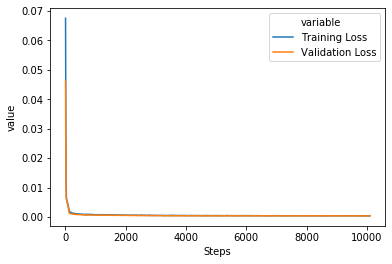

In [254]:
sns.lineplot(x='Steps', y='value', hue='variable', 
             data=pd.melt(trainingInfo, ['Steps']))

#### 4.2 Load the Best Training Result

In [16]:
def rebuldModel(pthPath="checkpoint.pth"):
    modelReload = LSTMRegressor()
    
    checkPoint = torch.load(pthPath)
    
    modelReload.load_state_dict(checkPoint['state_dict'])
    optimizerReload = torch.optim.Adam(modelReload.parameters(), lr=learning_rate)
    optimizerReload.load_state_dict(checkPoint['optimizer_state_dict'])
    
    return modelReload, optimizerReload

modelReload, optimizerReload = rebuldModel()
modelReload.to(device)

# put the model into evaluate mode
modelReload.eval()

LSTMRegressor(
  (lstm): LSTM(51, 30)
  (lstmOpen): LSTM(6, 6)
  (lstmPromo): LSTM(7, 7)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=43, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

#### 4.3 Inferance

I'll create two method to complete the inferance task.

- Inferance a single result with provided inputs
- Prepare data according to inferance needs

Two util methods are also created to help complete the inferance task.
- Generate historicall sales/open/promo data log with given store
- Extract the future open/promo status from test log with given store

In [23]:
# Still need to investigate missing values here for testData
testData.isin([np.NaN]).sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [24]:
# So if the OpenStatus is not clear, I'll just assume it's closed
testData.fillna(1, inplace=True)

In [25]:
# First create target stores full data with date, here use store1 for example first
def generatSeriesSalesOpenPromoDataFromStore(df=trainingDataYDf, attention=ATTENTION,
                                attentionPeriod=ATTENTIONPERIOD, Store=1, withDate=False):
    storeSalesStr = "Sales_{}".format(Store)
    storePromoStr = "Promo_{}".format(Store)
    storeOpenStr = "Open_{}".format(Store)

    if withDate==True:
        df = df.loc[:,['Date',storeSalesStr, storePromoStr, storeOpenStr]]
    else:
        df = df.loc[:,[storeStr]]

    df = df.iloc[-(df.shape[0] - (attention+attentionPeriod+1)):,:].reset_index(drop=True)
    df.rename(columns={storeSalesStr:'Sales', storePromoStr:'Promo', storeOpenStr:'Open'}, inplace=True)
    return df

# get the fullY
storeFullSalesPromoOpenData = generatSeriesSalesOpenPromoDataFromStore(df=trainingDataXDf, attention=ATTENTION, Store=1, withDate=True)
storeFullSalesPromoOpenData.head()

,Date,Sales,Promo,Open
0,2014-01-12,0.000000,0,0
1,2014-01-13,0.096123,0,1
2,2014-01-14,0.087146,0,1
3,2014-01-15,0.090876,0,1
4,2014-01-16,0.087411,0,1


In [26]:
# Then also create target store full open/promo status
def generatSeriesFutureOpenPromoFromStore(df=testData, Store=1):
    storeTable = df.loc[df['Store']==Store].copy()
    
    storeTable.sort_values(by='Date', ascending=True, inplace=True)
    
    tempdf = storeTable.loc[:,['Date', 'Open', 'Promo', 'Id']].reset_index(drop=True)
    
    return tempdf

storeFuturePromoOpenData = generatSeriesFutureOpenPromoFromStore(Store=1)
storeFuturePromoOpenData.head()

,Date,Open,Promo,Id
0,2015-08-01,1.0,0,40233
1,2015-08-02,0.0,0,39377
2,2015-08-03,1.0,1,38521
3,2015-08-04,1.0,1,37665
4,2015-08-05,1.0,1,36809


In [32]:
def inferanceSingle(model, lookback, attention, openSta, currentopen, promo):
    # Move data to default device
    lookback    = torch.tensor([lookback]).to(device)
    attention   = torch.tensor([attention]).to(device)
    openSta     = torch.tensor([openSta]).to(device)
    currentopen = torch.tensor([currentopen]).to(device)
    promo       = torch.tensor([promo]).to(device)

    with torch.no_grad():
        output = model(lookback, attention, openSta, currentopen, promo)
    
    # I always want output in cpu for follow computation
    output.cpu()

    return output

In [31]:
def inferanceFurture(model, dfHistory, dfFuture, predictNum):
    # inferance the future predictDay
    # - pdHistory is the dataframe contains historical sales, open, and promotion data
    # - dfFuture is the dataframe contain Open | Promo information for following days (T-0 ~ T+N)
    # - predictDate is the starting day of prediction
    # - predictNum is the days to predict
    outTemp = []
    
    lookback  = list(dfHistory.iloc[-LOOKBACK:, 1])
    attention = list(dfHistory.iloc[-365-ATTENTIONPERIOD-1:-365+ATTENTIONPERIOD, 1])
    openSta   = list(dfHistory.iloc[-OPENLOOKBACK:, 3])
    promo     = list(dfHistory.iloc[-PROMODATE+1:, 2])
    
    for i in range(predictNum):
        # get the latest currentOpen and promo
        currentopen = dfFuture.iloc[i, 1]
        promo.append(dfFuture.iloc[i, 2])

        out = inferanceSingle(model, lookback, attention, openSta, currentopen, promo)
        outTemp.append(out.cpu().numpy()[0][0])
        
        # shifting and preparing for next round
        temp = lookback.pop(0)
        lookback.append(out.cpu().numpy()[0][0])
        
        attention = list(dfHistory.iloc[i-365-ATTENTIONPERIOD:i-365+ATTENTIONPERIOD+1, 1])
        
        temp = openSta.pop(0)
        openSta.append(currentopen)
        
        temp = promo.pop(0)
    
    
    df = pd.DataFrame(list(zip(list(dfFuture.iloc[:, 3]), outTemp)), columns=['Id', 'Sales'])
    
    return df

Now test predict for store 1

In [552]:
predict = inferanceFurture(modelReload, storeFullSalesPromoOpenData, storeFuturePromoOpenData, len(storeFuturePromoOpenData))

### 5 Complete the Kaggle Submission Tasks
The final step is to complete the kaggle tasks by run through all the possible inferance tasks and generate the submission cvs file.

In [553]:
StoreId = testData['Store'].unique()
submit = pd.DataFrame([],columns=['Id', 'Sales'])

In [554]:
# Perform the prediciton
for id in StoreId:
    storeFullSalesPromoOpenData = generatSeriesSalesOpenPromoDataFromStore(df=trainingDataXDf,
                                                                           attention=ATTENTION, Store=id, withDate=True)
    
    storeFuturePromoOpenData = generatSeriesFutureOpenPromoFromStore(Store=id)
    
    tempPredict = inferanceFurture(modelReload, storeFullSalesPromoOpenData,
                                   storeFuturePromoOpenData, len(storeFuturePromoOpenData))
    
    submit = pd.concat([submit, tempPredict])

In [555]:
# Check point for future convinience
submit.to_csv("result.csv")
#submit = pd.read_csv("result.csv")
#submit.drop(submit.columns[submit.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [556]:
# Fisrt convert back to real sales number
submit['Sales'] = scalar.inverse_transform(submit['Sales'].values.reshape(-1,1))
# Then sort the values by Ids..
submit.sort_values(by='Id', ascending=True, inplace=True)

In [557]:
# Store to cvs for submission
submit.to_csv("submission.csv", index=False)

### 6 Generate the Graph for Report

#### 6.1 Step by Step Prediction Illustration
**Note** to run this, the trainingSet and validSet should be created in an approach that the sequence is preserved

In [561]:
# So I'll use the validation sets to generate the comparison graph
trainloader = torch.utils.data.DataLoader(trainingSet, batch_size=1, shuffle=False, pin_memory=True)
validloader = torch.utils.data.DataLoader(validSet, batch_size=1, shuffle=False, pin_memory=True)

In [17]:
predict = []
label = []

modelReload.eval()
with torch.no_grad():
    for lookback, attention, openSta, currentopen, promo, labels in validloader:
        # Move data to default device
        lookback    = lookback.to(device)
        attention   = attention.to(device)
        openSta     = openSta.to(device)
        currentopen = currentopen.to(device)
        promo       = promo.to(device)

        output = modelReload.forward(lookback, attention, openSta, currentopen, promo)
        
        predict.append(output.cpu().numpy()[0][0])
        label.append(labels.cpu().numpy()[0][0])

In [18]:
# generate training/validationg dataframe for further plotting
predictComparison = pd.DataFrame({
    'Steps': list(range(len(label))),
    'Real Sales': label,
    'Predicted Sales': predict
})

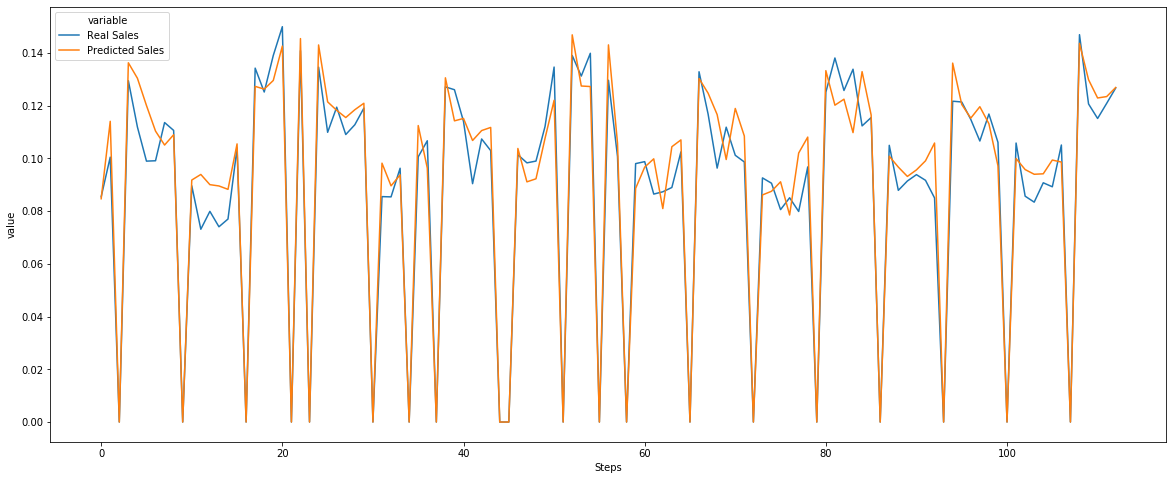

In [19]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(x='Steps', y='value', hue='variable', 
             data=pd.melt(predictComparison, ['Steps']))

#### 6.2 Last Month One Month Prediction
To better measure the prediction result, the last month data is extracted. The same data/format is used as inferance chapter. This is also intend to verify the implementation of previous inferance.

In [27]:
# so the last 30 days is removed as the SalesPromoOpenHistory data
tempSalesPromoOpenData = storeFullSalesPromoOpenData.iloc[:-30,:]

In [28]:
# and the last 30 days is used as the Future data
tempFuturePromoOpenData = storeFullSalesPromoOpenData.iloc[-30:,:]
tempFuturePromoOpenData = tempFuturePromoOpenData.loc[:,['Date', 'Open', 'Promo']]

# add a fake Id column
tempFuturePromoOpenData['Id'] = np.NaN

In [29]:
# the real sales is also read from here
labels = storeFullSalesPromoOpenData.iloc[-30:,:]
labels = labels.loc[:,['Sales']].reset_index(drop=True)

# rename the label name
labels.rename(columns={'Sales':'Real Sales'}, inplace=True)

In [33]:
# Now do the prediction
tempPredict = inferanceFurture(modelReload, tempSalesPromoOpenData,
                                   tempFuturePromoOpenData, len(tempFuturePromoOpenData))
tempPredict = tempPredict.drop(['Id'], axis=1)

In [34]:
tempdf = pd.concat([tempPredict, labels], axis=1)
tempdf['Step'] = list(range(len(tempPredict)))

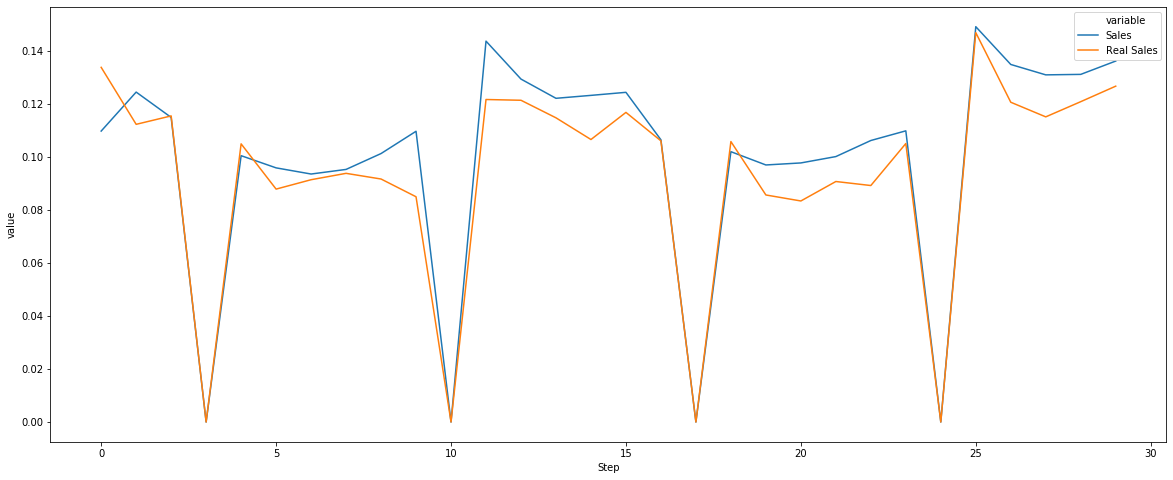

In [35]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(x='Step', y='value', hue='variable', 
             data=pd.melt(tempdf, 'Step'))

Now I'll print the RMSPE (Root mean square percentage error) for each prediction

In [52]:
rmspe = np.square((tempPredict.iloc[:,:].values.reshape(-1) - labels.iloc[:,:].values.reshape(-1))
                  /labels.iloc[:,:].values.reshape(-1))
rmspe = np.nan_to_num(rmspe)

<ipython-input-52-a52ce126f55e>:1: RuntimeWarning: invalid value encountered in true_divide
  rmspe = np.square((tempPredict.iloc[:,:].values.reshape(-1) - labels.iloc[:,:].values.reshape(-1))


[Text(0, 0.5, 'RMSPE Score'), Text(0.5, 0, 'Date')]

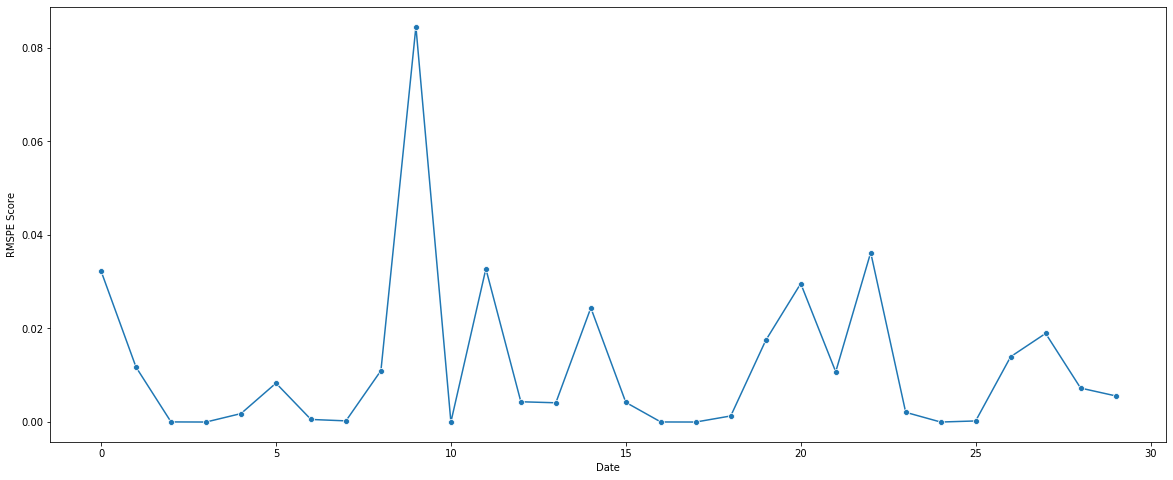

In [57]:
fig = plt.figure(figsize=(20,8))
ax = sns.lineplot(data=rmspe, marker="o")
ax.set(xlabel='Date', ylabel='RMSPE Score')

So from the result, the 30 days in a row prediction still shows quite good prediciton result. And especially some pattern, such as the peak right after shop close, are catched by the model.

Therefore, the task is concluded and finish.